Aujourd'hui, on parle des SAE (ou Auto Encodeurs Parcimonieux). C'est la technique derrière le fameux article d'Anthropic qui a fait dire à Claude qu'il est le Golden Bridge.

Ici j'entraîne un transformer sur le classique MNIST, puis j'extraie les activations du MLP (Multi-Layer Perceptron) lorsqu'on feedforward une image issue du MNIST.

J'entraîne un SAE avec ces activations, et il apprend tout seul quels sont les concepts importants de cette couche de MLP !

# Entraînement, probing, intervention avec SAE

## Mettre les choses en place

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_dataset
import numpy as np

Un mot concernant les paramètres.

C'est un petit modèle : deux couches de transformer, dont les dimensions sont de seulement 64.

En comparaison, pour être sûr et certain que le SAE va extraire les concepts de manière parcimonieuse, et en les distinguant les un des autres, j'ai un code de très grande dimension (sae_hidden_dim = 1024).

In [4]:
# Paramètres
batch_size = 1024
num_epochs = 5
learning_rate = 0.001
d_model = 64
nhead = 2
num_layers = 2
sae_hidden_dim = 256 #Une dimension qui doit impérativement être un carré, pour la visualisation

dataset = load_dataset("mnist")
train_dataset = dataset["train"]
test_dataset = dataset["test"]

def preprocess(examples):
    examples["pixel_values"] = [torch.tensor(np.array(img), dtype=torch.float32).view(1, 28, 28) / 255.0
                                for img in examples["image"]]
    return examples

train_dataset = train_dataset.map(preprocess, batched=True, remove_columns=["image"])
test_dataset = test_dataset.map(preprocess, batched=True, remove_columns=["image"])

train_dataset.set_format(type="torch", columns=["pixel_values", "label"])
test_dataset.set_format(type="torch", columns=["pixel_values", "label"])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/60000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [5]:
# Modèle Transformer
class MNISTTransformer(nn.Module):
    def __init__(self, d_model, nhead, num_layers, num_classes=10):
        super(MNISTTransformer, self).__init__()
        self.embedding = nn.Linear(28*28, d_model)
        self.pos_encoder = nn.Parameter(torch.randn(1, d_model))
        self.transformer_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
            for _ in range(num_layers)
        ])
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x, return_activations=False):
        x = x.view(x.size(0), -1)  # Aplatir l'image (batch_size, 784)
        x = self.embedding(x)  # (batch_size, d_model)
        x = x + self.pos_encoder  # Diffusion du pos_encoder
        x = x.unsqueeze(1)  # Ajouter une dimension de séquence (batch_size, 1, d_model)

        activations = None
        for i, layer in enumerate(self.transformer_layers):
            x = layer(x)
            if i == 1 and return_activations:
                activations = x.clone()

        x = x.squeeze(1)  # Retirer la dimension de séquence (batch_size, d_model)
        x = self.fc(x)

        if return_activations:
            return x, activations
        return x

Pour que le SAE soit vraiment pertinent, pas de non-linéarité, que du linéaire. Encodeur linéaire, décodeur linéaire.

In [6]:
# Modèle SAE
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        encoded = torch.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded, encoded

## Entraînement

Je mets un gros poids pour la parcimonie, parce que c'est quand même le but..

In [7]:
# Fonction d'entraînement du SAE
def train_sae(sae, activation_loader, num_epochs=100, learning_rate=0.001, sparsity_weight=1):
    optimizer = optim.Adam(sae.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        total_loss = 0
        for batch in activation_loader:
            batch = batch[0].to(device)
            optimizer.zero_grad()
            decoded, encoded = sae(batch)
            reconstruction_loss = criterion(decoded, batch)
            sparsity_loss = torch.mean(torch.abs(encoded))
            loss = reconstruction_loss + sparsity_weight * sparsity_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"SAE Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(activation_loader):.4f}")


évaluation pour l'accuracy et la loss

In [8]:
# Fonction d'évaluation pour le Transformer
def evaluate_transformer(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = batch['pixel_values'].to(device), batch['label'].to(device)
            outputs, _ = model(inputs, return_activations=True)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [9]:
# Initialisation des modèles
transformer = MNISTTransformer(d_model, nhead, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transformer.parameters(), lr=learning_rate)

# Entraînement du Transformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer.to(device)

MNISTTransformer(
  (embedding): Linear(in_features=784, out_features=64, bias=True)
  (transformer_layers): ModuleList(
    (0-1): 2 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (linear1): Linear(in_features=64, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=64, bias=True)
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (fc): Linear(in_features=64, out_features=10, bias=True)
)

In [10]:
for epoch in range(num_epochs):
    transformer.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = batch['pixel_values'].to(device), batch['label'].to(device)

        optimizer.zero_grad()
        outputs, _ = transformer(inputs, return_activations=True)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)

    # Évaluation sur l'ensemble de test
    test_loss, test_accuracy = evaluate_transformer(transformer, test_loader, criterion, device)

    print(f"Transformer Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

print("Entraînement du Transformer terminé!")

Transformer Epoch [1/5]
  Train Loss: 1.0163
  Test Loss: 0.3086, Test Accuracy: 91.25%
Transformer Epoch [2/5]
  Train Loss: 0.2573
  Test Loss: 0.2028, Test Accuracy: 94.17%
Transformer Epoch [3/5]
  Train Loss: 0.1815
  Test Loss: 0.1553, Test Accuracy: 95.44%
Transformer Epoch [4/5]
  Train Loss: 0.1334
  Test Loss: 0.1144, Test Accuracy: 96.60%
Transformer Epoch [5/5]
  Train Loss: 0.1091
  Test Loss: 0.1101, Test Accuracy: 96.89%
Entraînement du Transformer terminé!


Une fois le transformer entraîné, on collecte les activations de la couche de MLP...

In [11]:
# Collecter les activations
transformer.eval()
activations = []
with torch.no_grad():
    for batch in train_loader:
        inputs = batch['pixel_values'].to(device)
        _, batch_activations = transformer(inputs, return_activations=True)
        activations.append(batch_activations.squeeze(1).cpu())

activations = torch.cat(activations, dim=0)

...et on entraîne notre SAE

In [12]:
# Initialiser et entraîner le SAE
sae = SparseAutoencoder(d_model, sae_hidden_dim)
sae.to(device)
activation_dataset = TensorDataset(activations)
activation_loader = DataLoader(activation_dataset, batch_size=batch_size, shuffle=True)
train_sae(sae, activation_loader)

print("Entraînement du SAE terminé!")

SAE Epoch [1/100], Loss: 0.5349
SAE Epoch [2/100], Loss: 0.2084
SAE Epoch [3/100], Loss: 0.1532
SAE Epoch [4/100], Loss: 0.1219
SAE Epoch [5/100], Loss: 0.1018
SAE Epoch [6/100], Loss: 0.0877
SAE Epoch [7/100], Loss: 0.0777
SAE Epoch [8/100], Loss: 0.0701
SAE Epoch [9/100], Loss: 0.0642
SAE Epoch [10/100], Loss: 0.0595
SAE Epoch [11/100], Loss: 0.0556
SAE Epoch [12/100], Loss: 0.0523
SAE Epoch [13/100], Loss: 0.0495
SAE Epoch [14/100], Loss: 0.0471
SAE Epoch [15/100], Loss: 0.0450
SAE Epoch [16/100], Loss: 0.0431
SAE Epoch [17/100], Loss: 0.0414
SAE Epoch [18/100], Loss: 0.0398
SAE Epoch [19/100], Loss: 0.0384
SAE Epoch [20/100], Loss: 0.0371
SAE Epoch [21/100], Loss: 0.0359
SAE Epoch [22/100], Loss: 0.0349
SAE Epoch [23/100], Loss: 0.0339
SAE Epoch [24/100], Loss: 0.0330
SAE Epoch [25/100], Loss: 0.0321
SAE Epoch [26/100], Loss: 0.0313
SAE Epoch [27/100], Loss: 0.0306
SAE Epoch [28/100], Loss: 0.0299
SAE Epoch [29/100], Loss: 0.0292
SAE Epoch [30/100], Loss: 0.0286
SAE Epoch [31/100],

## Visualisation

Ce code permet de visualiser toutes les étapes intéressantes.

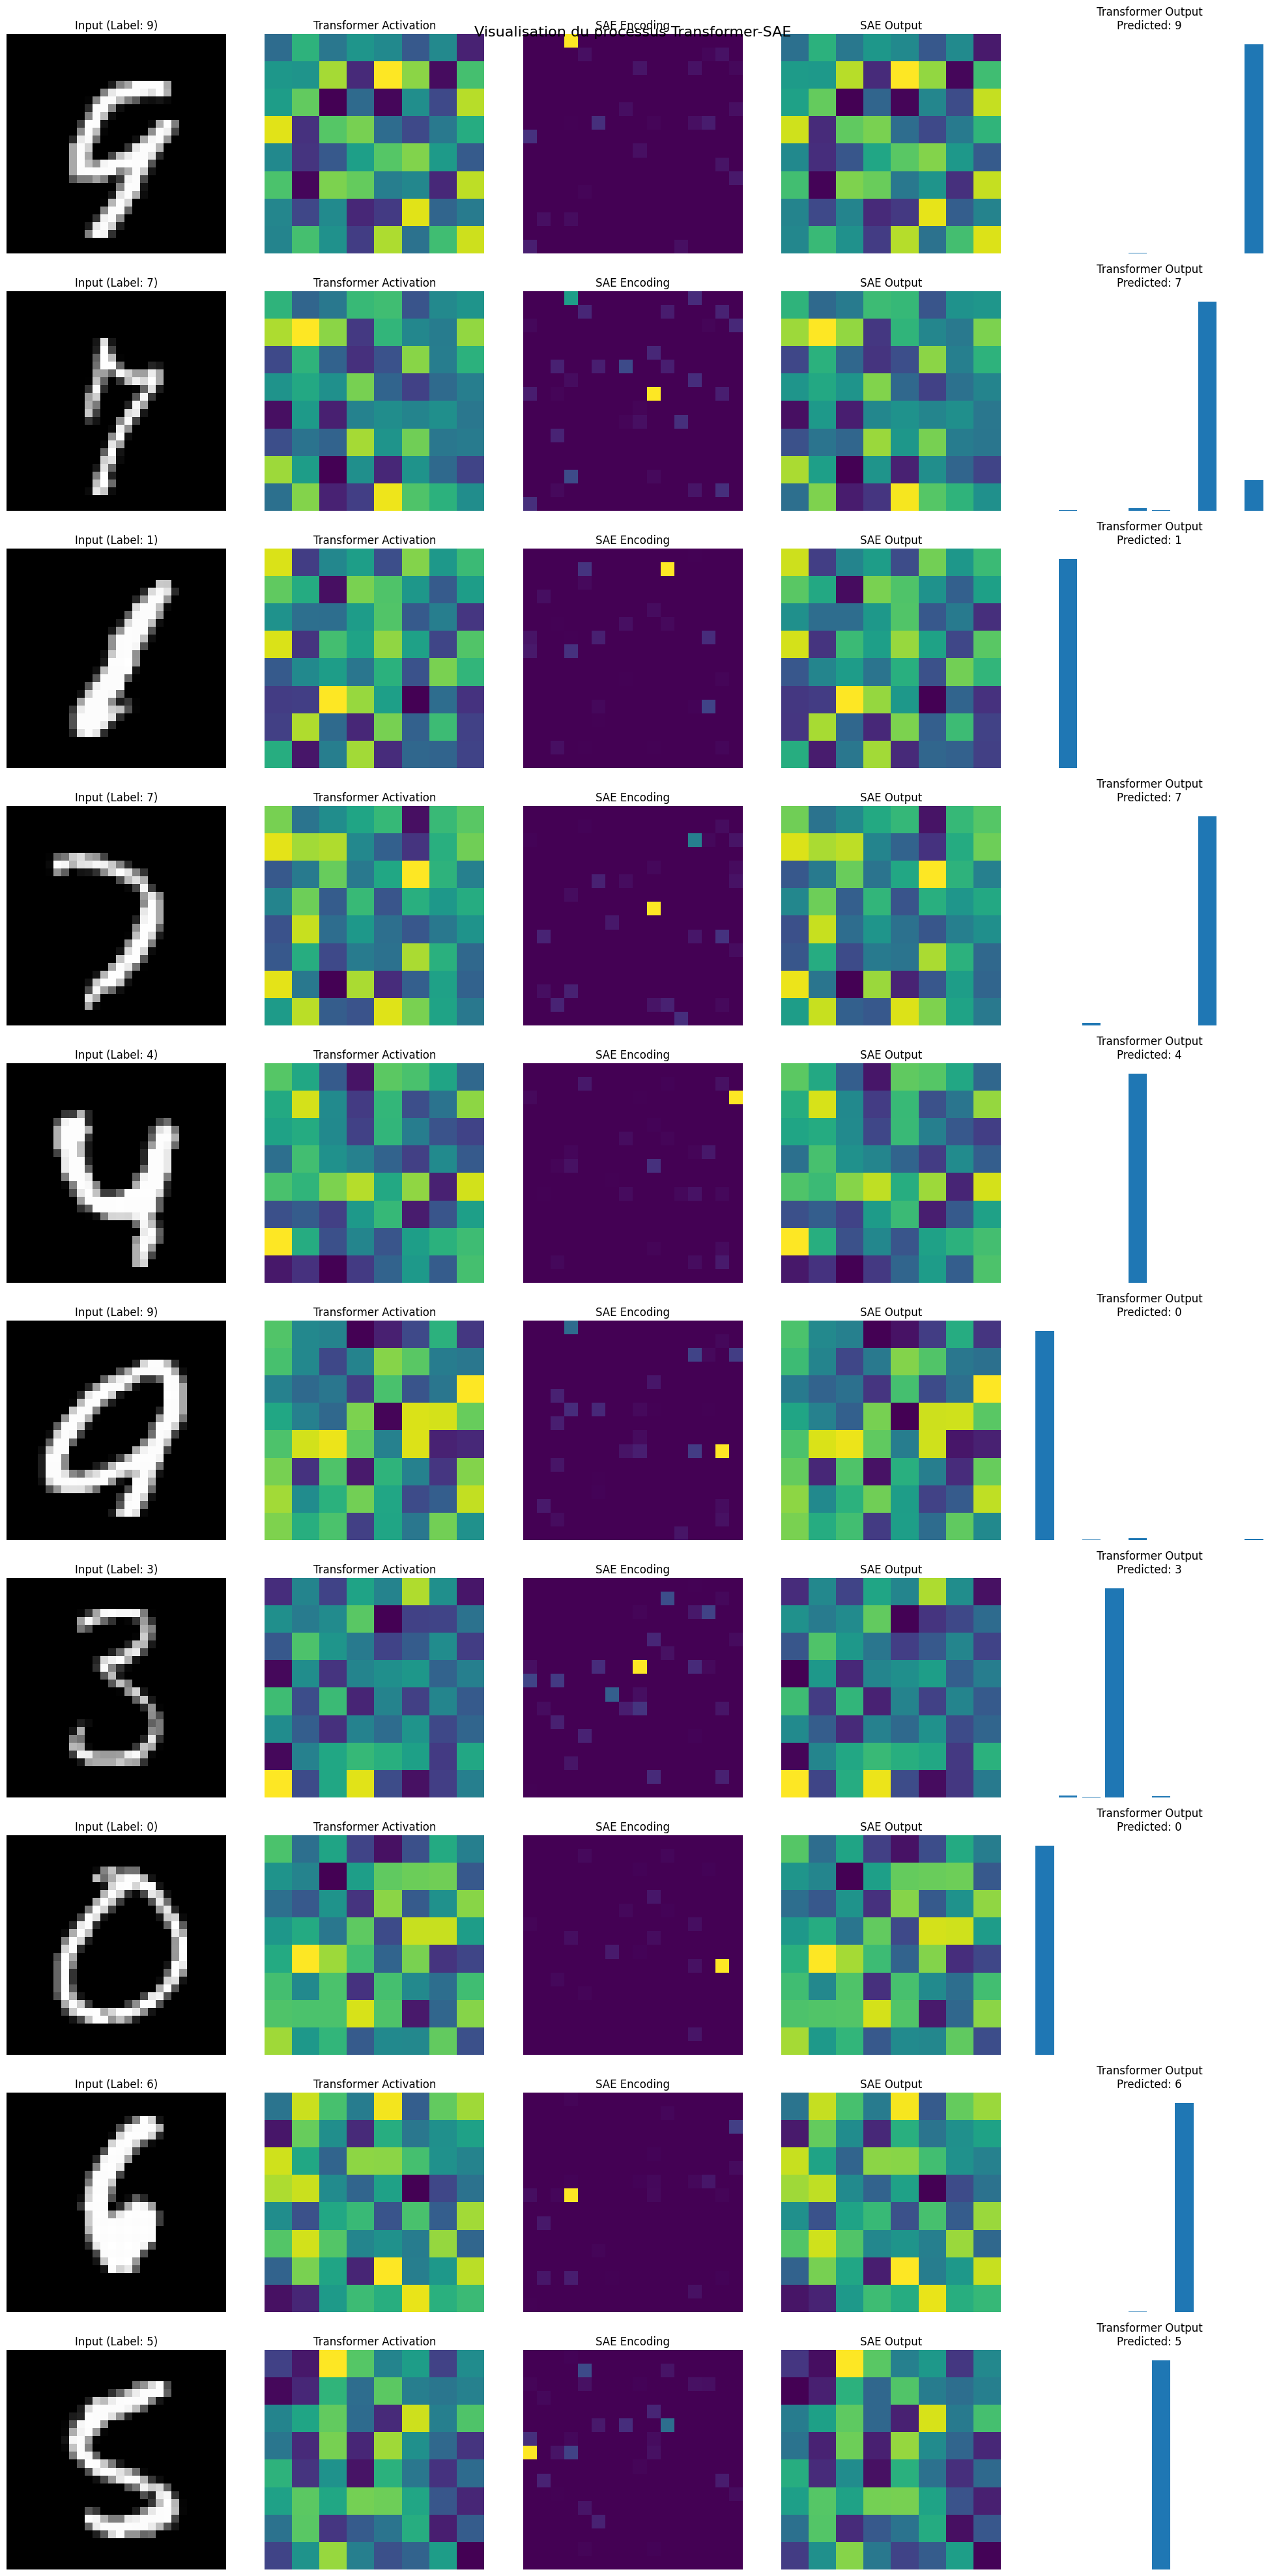

In [13]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
import random

def visualize_process(transformer, sae, test_loader, num_samples=10):
    device = next(transformer.parameters()).device
    transformer.eval()
    sae.eval()

    # Sélectionner des échantillons aléatoires
    all_samples = []
    for batch in test_loader:
        all_samples.extend(list(zip(batch['pixel_values'], batch['label'])))
    random_samples = random.sample(all_samples, num_samples)

    fig, axs = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))
    fig.suptitle("Visualisation du processus Transformer-SAE", fontsize=16)

    for i, (image, label) in enumerate(random_samples):
        image = image.to(device)

        # Image originale
        axs[i, 0].imshow(image.cpu().squeeze().numpy(), cmap='gray')
        axs[i, 0].set_title(f"Input (Label: {label})")

        # Transformer activation
        with torch.no_grad():
            transformer_output = transformer(image.unsqueeze(0), return_activations=True)
            transformer_activation = transformer_output[-1].squeeze().cpu()

        # SAE encoding et decoding
        with torch.no_grad():
            sae_output, sae_encoding = sae(transformer_activation.to(device))

        # Affichage de l'activation du Transformer
        axs[i, 1].imshow(transformer_activation.numpy().reshape(int(np.sqrt(transformer_activation.shape[0])), -1), cmap='viridis')
        axs[i, 1].set_title("Transformer Activation")

        # Affichage de l'encodage SAE
        axs[i, 2].imshow(sae_encoding.cpu().numpy().reshape(int(np.sqrt(sae_encoding.shape[0])), -1), cmap='viridis')
        axs[i, 2].set_title("SAE Encoding")

        # Affichage de la sortie SAE
        axs[i, 3].imshow(sae_output.cpu().numpy().reshape(int(np.sqrt(sae_output.shape[0])), -1), cmap='viridis')
        axs[i, 3].set_title("SAE Output")

        # Affichage de la sortie du Transformer
        with torch.no_grad():
            transformer_output = transformer(image.unsqueeze(0))
        predicted_class = torch.argmax(transformer_output).item()
        axs[i, 4].bar(range(10), nn.functional.softmax(transformer_output.squeeze(), dim=0).cpu().numpy())
        axs[i, 4].set_title(f"Transformer Output\nPredicted: {predicted_class}")
        axs[i, 4].set_xticks(range(10))

    for ax in axs.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Utilisation de la fonction
visualize_process(transformer, sae, test_loader)

Description :

* première colonne : input du transformer
* deuxième : état de la couche de sortie du MLP dans le transformer
* troisième : état de la couche de code du SAE, qui a été entraîné sur ladite couche de sortie du MLP
* quatrième : couche prédite par le SAE après décodage (identique à l'entrée donc)
* cinquième : output du transformer, c'est-à dire une distribution sur les labels des chiffres. Tellement bien entraîné qu'il est certain...

## Intervention !! (partie la plus intéressante)

Ci dessous, le code pour intervenir sur les neurones directement.

In [14]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random

def visualize_process_with_intervention(transformer, sae, test_loader, num_samples=2, neuron_position=None, intensity=1.0):
    device = next(transformer.parameters()).device
    transformer.eval()
    sae.eval()

    all_samples = []
    for batch in test_loader:
        all_samples.extend(list(zip(batch['pixel_values'], batch['label'])))
    random_samples = random.sample(all_samples, num_samples)

    fig, axs = plt.subplots(num_samples, 7, figsize=(28, 4*num_samples))
    fig.suptitle(f"Visualisation du processus Transformer-SAE avec intervention (Neurone: {neuron_position}, Intensité: {intensity})", fontsize=16)

    for i, (image, label) in enumerate(random_samples):
        image = image.to(device)

        # Image originale
        axs[i, 0].imshow(image.cpu().squeeze().numpy(), cmap='gray')
        axs[i, 0].set_title(f"Input (Label: {label})")

        # Transformer activation
        with torch.no_grad():
            original_output, transformer_activation = transformer(image.unsqueeze(0), return_activations=True)
            transformer_activation = transformer_activation.squeeze().cpu()

        # SAE encoding et decoding
        with torch.no_grad():
            sae_output, sae_encoding = sae(transformer_activation.to(device))

        # Affichage de l'activation du Transformer
        axs[i, 1].imshow(transformer_activation.numpy().reshape(int(np.sqrt(transformer_activation.shape[0])), -1), cmap='viridis')
        axs[i, 1].set_title("Transformer Activation")

        # Affichage de l'encodage SAE original
        axs[i, 2].imshow(sae_encoding.cpu().numpy().reshape(int(np.sqrt(sae_encoding.shape[0])), -1), cmap='viridis')
        axs[i, 2].set_title("SAE Encoding (Original)")

        # Intervention manuelle sur l'encodage SAE
        modified_encoding = sae_encoding.clone()
        if neuron_position is not None:
            modified_encoding[neuron_position] += intensity
        else:
            # Si aucun neurone spécifique n'est choisi, on modifie le premier quart comme avant
            region_size = sae_encoding.shape[0] // 4
            modified_encoding[:region_size] *= intensity

        # Affichage de l'encodage SAE modifié
        axs[i, 3].imshow(modified_encoding.cpu().numpy().reshape(int(np.sqrt(modified_encoding.shape[0])), -1), cmap='viridis')
        axs[i, 3].set_title("SAE Encoding (Modified)")

        # Décodage de l'encodage modifié
        with torch.no_grad():
            modified_output = sae.decoder(modified_encoding.to(device))

        # Affichage de la sortie SAE modifiée
        axs[i, 4].imshow(modified_output.cpu().numpy().reshape(int(np.sqrt(modified_output.shape[0])), -1), cmap='viridis')
        axs[i, 4].set_title("Modified SAE Output")

        # Affichage de la sortie du Transformer original
        original_predicted_class = torch.argmax(original_output).item()
        axs[i, 5].bar(range(10), nn.functional.softmax(original_output.squeeze(), dim=0).cpu().numpy())
        axs[i, 5].set_title(f"Original Output\nPredicted: {original_predicted_class}")
        axs[i, 5].set_xticks(range(10))

        # Calcul de la sortie du Transformer avec intervention
        with torch.no_grad():
            # Préparation des données pour le passage à travers le transformer
            x = image.view(1, -1)  # Aplatir l'image (1, 784)
            x = transformer.embedding(x)  # (1, d_model)
            x = x + transformer.pos_encoder  # Diffusion du pos_encoder
            x = x.unsqueeze(1)  # Ajouter une dimension de séquence (1, 1, d_model)

            # Passage à travers les couches du transformer
            for j, layer in enumerate(transformer.transformer_layers):
                if j == 1:
                    # Remplacer l'activation de la deuxième couche par l'activation modifiée
                    x = modified_output.unsqueeze(0).unsqueeze(0)
                else:
                    x = layer(x)

            x = x.squeeze(1)  # Retirer la dimension de séquence (1, d_model)
            modified_transformer_output = transformer.fc(x)

        modified_predicted_class = torch.argmax(modified_transformer_output).item()
        axs[i, 6].bar(range(10), nn.functional.softmax(modified_transformer_output.squeeze(), dim=0).cpu().numpy())
        axs[i, 6].set_title(f"Modified Output\nPredicted: {modified_predicted_class}")
        axs[i, 6].set_xticks(range(10))

    for ax in axs.flat:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Utilisation de la fonction
# Pour modifier un neurone spécifique, utilisez :
# visualize_process_with_intervention(transformer, sae, test_loader, neuron_position=42, intensity=2.0)
# Pour modifier une région, utilisez :
# visualize_process_with_intervention(transformer, sae, test_loader, intensity=2.0)
# visualize_process_with_intervention(transformer, sae, test_loader)

Usage : Pour modifier un neurone, mettez `neuron_position` = `index` du neurone que vous voulez triturer, et changez son intensité !

**Tu es un zéro, Harry**

Comment persuader un transformer qu'il voit un zéro, alors qu'il a un autre chiffre devant ses yeux ?

Le neurone lié au 0 dans le SAE (ici) est le **neurone 158**. L'intensité est fixée à 2, ce qui permet de compenser les autres neurones déjà activer, pour forcer les choses.

Note : à chaque entraînement du modèle, la place du neurone change, il faut donc observer attentivement la position du neurone en question dans la sortie au dessus.

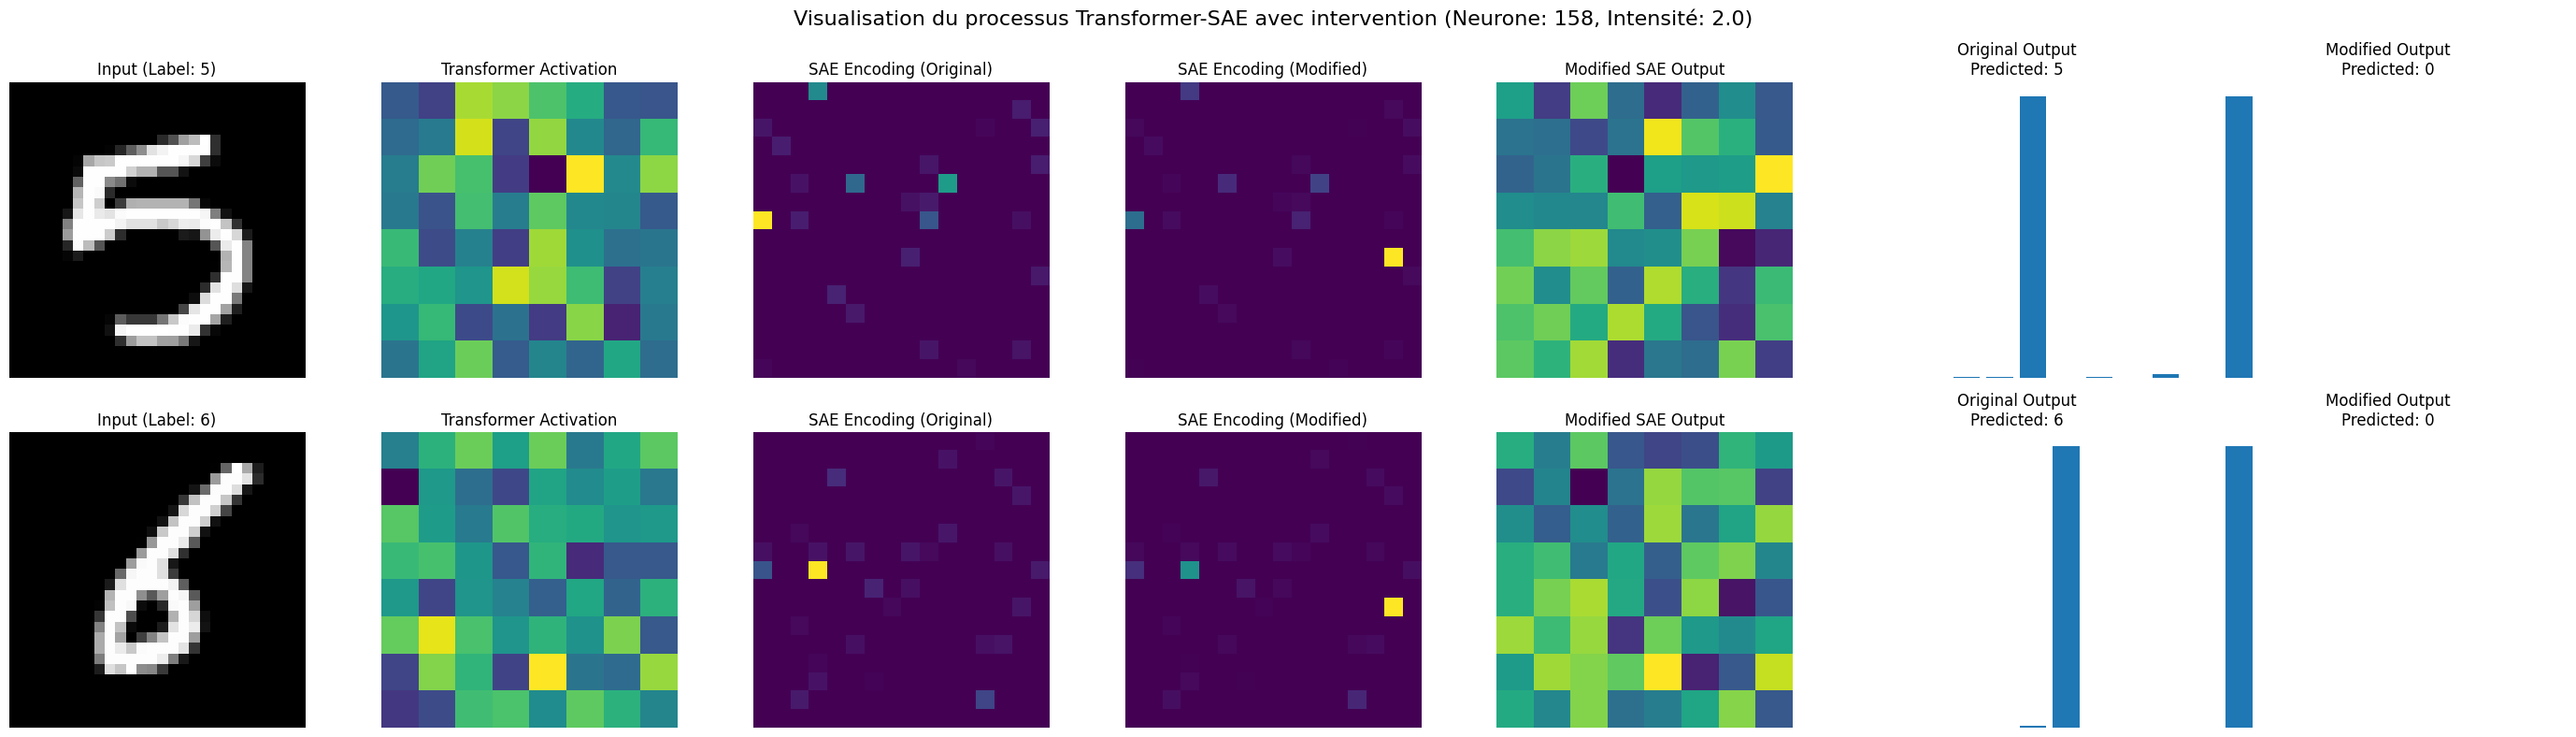

In [17]:
visualize_process_with_intervention(transformer, sae, test_loader, neuron_position=158, intensity=2.0)

*Et voilà comment on finit par croire qu'on est le Golden Bridge...*

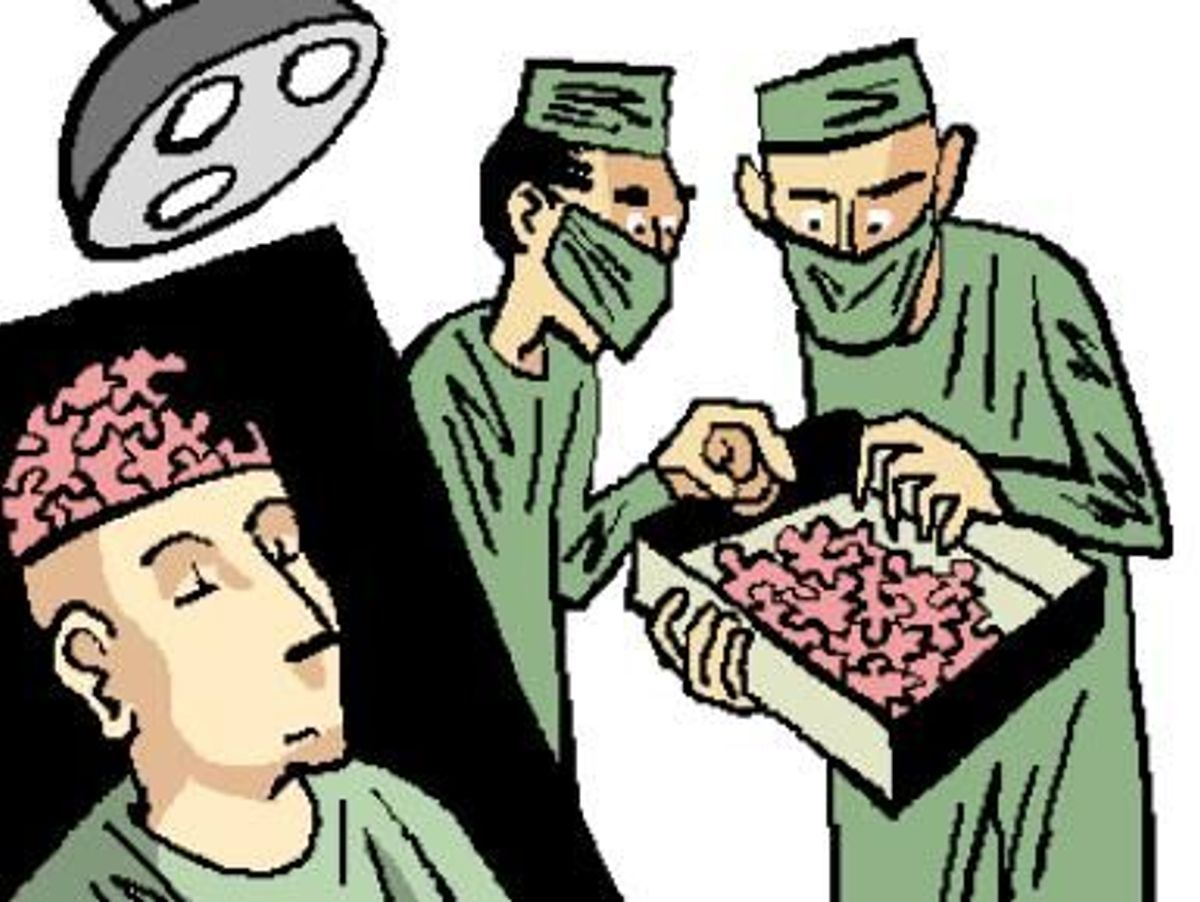